## DataWorkshop - NLP - konkurs

In [29]:
import pandas as pd
import numpy as np
np.random.seed(0)

import tensorflow as tf


import xgboost as xgb
import catboost as ctb

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from keras_bert import load_trained_model_from_checkpoint
from transformers import BertTokenizer


import joblib
import random
import re

import texthero as hero
import spacy
from spacy import displacy
from collections import defaultdict, Counter

from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Conv1D, MaxPool1D, Dropout, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.preprocessing.text as kpt 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from livelossplot import PlotLossesKeras
import tensorflow.keras.backend as K


from scikitplot.estimators import plot_learning_curve
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def init_tokenizer_and_load_bert(model_name='uncased_L-2_H-128_A-2', do_lower_case=True, model_trainable=False):
    models_in_module4 = '/home/<login>/nlp1/module4/models/'
    config_path = models_in_module4 + model_name + '/bert_config.json'
    checkpoint_path = models_in_module4 + model_name +'/bert_model.ckpt'
    vocab_path = models_in_module4 + model_name + '/vocab.txt'
    
    print("loading: {}".format(model_name))
    
    tokenizer = BertTokenizer(vocab_path)
    print("vocab size: {}".format(len(tokenizer.vocab)))
    
    model = load_trained_model_from_checkpoint(config_path, checkpoint_path, training=model_trainable)
    print("loaded: {}".format(model_name))
    
    return tokenizer, model

def get_model_inputs(df):
    df['input_ids'] = df['tokens'].map(lambda t: t['input_ids'] )
    df['token_type_ids'] = df['tokens'].map(lambda t: t['token_type_ids'] )
    df['attention_mask'] = df['tokens'].map(lambda t: t['attention_mask'] )
    
    return np.stack(df['input_ids']), np.stack(df['token_type_ids']), np.stack(df['attention_mask'])

def get_X_from_bert(df, text='text', model_name='uncased_L-2_H-128_A-2'):
    tokenizer, bert_model = init_tokenizer_and_load_bert(model_name)
    
    tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
    %time df['tokens'] = df[text].map(tokenize)
    
    input_ids, token_type_ids, attention_mask = get_model_inputs(df)
    print("{}, {}, {}".format(input_ids.shape, token_type_ids.shape, attention_mask.shape))
    
    predicts = bert_model.predict([input_ids, token_type_ids, attention_mask], verbose=1)
    
    X = predicts[:, 0 , :]

    return X

def get_y(df, column='is_fake'):
    return df[column].factorize()[0]

def fit_predict_save(X, y, model, df, text_column='text', file_name='predict'):
    model.fit(X, y)
    X_test = get_X_from_bert(df, text_column)
    print("X_test.shape: {}".format(X_test.shape))
    df['is_fake'] = model.predict(X_test)
    df[ ['id', 'is_fake'] ].to_csv('konkurs_out/{}.csv'.format(file_name), index=False)

def predict_and_plot(X, y, model):
    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')

    print('roc_auc: {} {}'.format(np.mean(scores), np.std(scores)))
    plot_learning_curve(model, X, y, cv=3, train_sizes=np.linspace(.55, 1.0, 5), scoring='roc_auc')
    
def plot_conf_matrix(X, y, model):
    xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.33)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    get_roc_auc_score(ytest, ypred)
    plot_confusion_matrix(ytest,ypred)
    plt.show() 
    
def get_roc_auc_score(y_true, y_scores):
    score = roc_auc_score(y_true, y_scores)
    print("AUC is: {}".format(score))
    return score

def words_len(df, column='text'):
    new_column = '{}_len'.format(column)
    df[new_column] = df[column].map(lambda x: len(x))

    for percentile in [50, 75, 80, 85, 90, 95, 98, 99, 100]:
        print(percentile, np.percentile(df[new_column], percentile))
    
    df[new_column].hist(bins=50);

def my_split(sentence, separator=','):
    return sentence.split(separator)    

def my_split_and_merge(sentence, separator=','):
    sentences = sentence.split(separator)
    return ", ".join([" ".join(s.split('-')) for s in sentences])

def remove_stop_words(df, stop_words, column_name='title', new_column_name='title_clean'):
    df[new_column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
    
def re_urls(text, replace_for="URL"):
    return re.sub(r'https?://\S+', replace_for, text) 

def re_user_mentioned(text, replace_for=r'\1'):
    #replace_for='--AT-USER--'
    #return re.sub(r'\S+', replace_for, text)    
    return re.sub(r'@(\S+)', replace_for, text)

def re_digits(text, replace_for='DIGIT'): 
    result = re.sub(r'\d+', replace_for, text) 
    return result

def re_multi_spaces_into_one(text, replace_for=' '):
    return re.sub(r'\s+', replace_for, text)

def re_topic(text, replace_for=r'\1'):
    return re.sub(r'#(\S+)', replace_for, text)
       
def make_unescape(text):
    return unescape(text)    

def re_covid(text, replace_for='COVID'): 
    result = re.sub(r'COVID-19', replace_for, text) 
    result = re.sub(r'covid-19', 'covid', result)
    return result

def re_quote(text):
    return re.sub(r'\'', '', text)

def re_slash(text): 
    result = re.sub(r'\'', '', text)
    return result

def avg_word_length(sentence):
    filtered = ''.join(filter(lambda x: x not in '".,;!-', sentence))
    words = [word for word in filtered.split() if word]
    avg = 0
    if(len(words) > 0):
        avg = sum(map(len, words))/len(words)
    return avg

def avg_word_length(sentence):
    filtered = ''.join(filter(lambda x: x not in '".,;!-', sentence))
    words = [word for word in filtered.split() if word]
    avg = 0
    if(len(words) > 0):
        avg = sum(map(len, words))/len(words)
    return avg

def num_words(sentence):
    filtered = ''.join(filter(lambda x: x not in '".,;!-', sentence))
    return len([word for word in filtered.split() if word])

def num_upper(sentence):
    filtered = ''.join(filter(lambda x: x not in '".,;!-', sentence))
    words = [word for word in filtered.split() if word]
    return sum(map(str.istitle, words))

def preprocessing_remove(df):
    df['combined_clean'] = hero.clean(df.combined) # zawiera dane wyczyszczone przez hero.clean()
    
    # usuwamy wyrazy występujące najczęściej i tylko raz, wynik zapisujemy do kolumny 'combined_clean_rarely'
    a = hero.visualization.top_words(df.combined_clean).sort_values()
    b =  pd.DataFrame(a)
    rarely_words = b[ b["combined_clean"] == 1].index.tolist() # mamy 5482 takich słów
    rarely_words.append('al') # z najpolularniejszych słów usuwamy tylko 'al' które występuje w 2648 wierszach
    remove_stop_words(df, rarely_words, column_name='combined_clean', new_column_name='combined_clean_rarely')
    return df

def preprocessing_features(df, column_clean = 'combined_clean_rarely'):
    df[column_clean] = df[column_clean].map(re_quote)
    df['avg_word_length'] = df[column_clean].map(avg_word_length)
    df['num_words'] = df[column_clean].map(num_words)
    # z jakim zestawem danych mamy do czynienia
    df['set_title'] = np.where(df['text_c'] != "", 1, 0)  # title jest/nie jest NaN
    df['set_text'] = np.where(df['text_c'] == "", 0, 1)   # text jest/nie jest NaN
    df['set_words'] = np.where(df['title_up'] == 0, 1, 0) # title jest zadaniem/ jest listą kategorii

def calc_embeddings(text, embeddings):
    sent = Sentence(text)
    embeddings.embed(sent)
    return np.array(sent.embedding)

def plot_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    centroids = kmeans.cluster_centers_
    y_pred = kmeans.predict(X)

    plt.figure(figsize=(15, 5))
    sns.scatterplot(X[:,0], X[:,1], hue=y_pred);
    return y_pred

def calculate_WSS(X, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters=k).fit(X)
        centroids = kmeans.cluster_centers_
        y_pred = kmeans.predict(X)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(X)):
            curr_center = centroids[y_pred[i]]
            curr_sse += (X[i, 0] - curr_center[0]) ** 2 + (X[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

In [8]:
def prepare_data(df):
    df["text_c"] = df["text"].replace(np.nan, "")
    df["title"] = df["title"].replace(np.nan, "")
    df['combined']=df.apply(lambda x:'%s. %s' % (x['title'],x['text_c']),axis=1)
    df['text_m'] = np.where(df['text_c'] == "", df['title'], df['text_c'])
    df['title_split'] = np.where(df['text_c'] != "", df['title'].map(my_split), "")
    df['title_split_m'] = np.where(df['title'] != "", df['title'].map(my_split_and_merge), "")
    df['title_up'] = df['title'].str.findall(r'[A-Z]').str.len()
    df['title_lo'] = df['title'].str.findall(r'[a-z]').str.len()
    df['text_up'] = df['text_c'].str.findall(r'[A-Z]').str.len()
    df['text_lo'] = df['text_c'].str.findall(r'[a-z]').str.len()
    df['title_len'] = df['title'].str.len().astype(int)
    df['text_len'] = df['text_c'].str.len().astype(int)
    df['avg_word_length_org'] = df['combined'].map(avg_word_length)
    df['num_words_org'] = df['combined'].map(num_words)
    df['num_nums'] = df['combined'].str.findall(r'[0-9]').str.len()
    df['num_upper'] = df['combined'].map(num_upper)

In [4]:
train_fake = pd.read_hdf("../input/train_fake.h5")
test_fake = pd.read_hdf("../input/test_fake.h5")

train_fake.shape, test_fake.shape

((4862, 4), (4863, 3))

In [9]:
prepare_data(train_fake)
prepare_data(test_fake)

In [10]:
train_fake.sample(5)

,id,title,text,is_fake,text_c,combined,text_m,title_split,title_split_m,title_up,title_lo,text_up,text_lo,title_len,text_len,avg_word_length_org,num_words_org,num_nums,num_upper
2471,5019,taxes,David Dewhurst has a record of promoting an in...,1,David Dewhurst has a record of promoting an in...,taxes. David Dewhurst has a record of promotin...,David Dewhurst has a record of promoting an in...,[taxes],taxes,0,5,2,43,5,55,4.545455,11,0,2
2977,6016,"immigration,military",We dont have a (military) reserve force if som...,1,We dont have a (military) reserve force if som...,"immigration,military. We dont have a (military...",We dont have a (military) reserve force if som...,"[immigration, military]","immigration, military",0,19,1,48,20,61,6.363636,11,0,1
3972,8043,US Representatives Promise Implement Of UN Gun...,NaN,1,,US Representatives Promise Implement Of UN Gun...,US Representatives Promise Implement Of UN Gun...,,US Representatives Promise Implement Of UN Gun...,11,41,0,0,60,0,6.500000,8,0,5
31,76,The Economic Burden Caused by Tax Code Complexity,NaN,0,,The Economic Burden Caused by Tax Code Complex...,The Economic Burden Caused by Tax Code Complexity,,The Economic Burden Caused by Tax Code Complexity,7,35,0,0,49,0,5.250000,8,0,7
2034,4135,"sexuality,technology",A poll found that 20% of young adults use (sma...,0,A poll found that 20% of young adults use (sma...,"sexuality,technology. A poll found that 20% of...",A poll found that 20% of young adults use (sma...,"[sexuality, technology]","sexuality, technology",0,19,1,49,20,67,5.692308,13,2,1


In [ ]:
#------------------------------------------------------------

Czyścimy dane (hero.clean(), usuwamy wyrazy występujące najczęściej i tylko raz)

In [19]:
preprocessing_remove(train_fake)
preprocessing_remove(test_fake)
train_fake.shape, test_fake.shape

((4862, 23), (4863, 22))

Dodajemy ficzery

In [23]:
preprocessing_features(train_fake)
preprocessing_features(test_fake)
train_fake.shape, test_fake.shape

((4862, 26), (4863, 25))

In [24]:
train_fake.sample(5)

,id,title,text,is_fake,text_c,combined,text_m,title_split,title_split_m,title_up,...,num_words_org,num_nums,num_upper,combined_clean,combined_clean_rarely,avg_word_length,num_words,set_title,set_text,set_words
1879,3820,Deadly Blast Hits South Damascus,24-09-2013 Deadly Blast Hits South Damascus. T...,1,24-09-2013 Deadly Blast Hits South Damascus. T...,Deadly Blast Hits South Damascus. 24-09-2013 D...,24-09-2013 Deadly Blast Hits South Damascus. T...,[Deadly Blast Hits South Damascus],Deadly Blast Hits South Damascus,5,...,113,15,17,deadly blast hits south damascus deadly blast ...,deadly blast hits south damascus deadly blast ...,6.619718,71,1,1,0
2729,5518,Trump Nation,NaN,1,,Trump Nation.,Trump Nation,,Trump Nation,2,...,2,0,2,trump nation,trump nation,5.500000,2,0,0,0
368,754,People who smoke may have more receptors for t...,NaN,0,,People who smoke may have more receptors for t...,People who smoke may have more receptors for t...,,People who smoke may have more receptors for t...,1,...,10,0,1,people smoke may receptors new,people smoke may new,4.250000,4,0,0,0
1148,2322,immigration,"Says using E-Verify is a fair amount of cost, ...",0,"Says using E-Verify is a fair amount of cost, ...",immigration. Says using E-Verify is a fair amo...,"Says using E-Verify is a fair amount of cost, ...",[immigration],immigration,0,...,18,2,1,immigration says using e verify fair amount co...,immigration says using e verify fair amount co...,5.000000,11,1,1,1
4325,8706,Training Case Investigators and Contact Tracers,NaN,0,,Training Case Investigators and Contact Tracers.,Training Case Investigators and Contact Tracers,,Training Case Investigators and Contact Tracers,5,...,6,0,5,training case investigators contact tracers,training case investigators contact tracers,7.800000,5,0,0,0


Obliczamy wektory, model BERT uncased_L-12_H-768_A-12

In [32]:
X = get_X_from_bert(train_fake, 'combined_clean_rarely', model_name='uncased_L-12_H-768_A-12')
X_test = get_X_from_bert(test_fake, 'combined_clean_rarely', model_name='uncased_L-12_H-768_A-12')

loading: uncased_L-12_H-768_A-12
vocab size: 30522
loaded: uncased_L-12_H-768_A-12
CPU times: user 2.89 s, sys: 68 ms, total: 2.96 s
Wall time: 2.96 s
(4862, 512), (4862, 512), (4862, 512)
152/152 [==============================] - ETA:  - ETA: 14:3 - ETA: 19:3 - ETA: 21:4 - ETA: 23:1 - ETA: 24:1 - ETA: 24:4 - ETA: 25:0 - ETA: 25:1 - ETA: 26:2 - ETA: 26:3 - ETA: 26:2 - ETA: 26:2 - ETA: 26:1 - ETA: 26:1 - ETA: 26:5 - ETA: 26:4 - ETA: 26:3 - ETA: 26:1 - ETA: 25:5 - ETA: 25:4 - ETA: 25:2 - ETA: 25:1 - ETA: 24:5 - ETA: 24:4 - ETA: 24:2 - ETA: 24:1 - ETA: 24:0 - ETA: 23:4 - ETA: 23:3 - ETA: 23:2 - ETA: 23:0 - ETA: 22:5 - ETA: 22:4 - ETA: 22:3 - ETA: 22:1 - ETA: 22:0 - ETA: 21:5 - ETA: 21:3 - ETA: 21:2 - ETA: 21:1 - ETA: 21:0 - ETA: 20:4 - ETA: 20:3 - ETA: 20:2 - ETA: 20:1 - ETA: 20:0 - ETA: 19:5 - ETA: 19:4 - ETA: 19:3 - ETA: 19:2 - ETA: 19:0 - ETA: 18:5 - ETA: 18:4 - ETA: 18:4 - ETA: 18:3 - ETA: 18:2 - ETA: 18:0 - ETA: 17:5 - ETA: 17:4 - ETA: 17:3 - ETA: 17:2 - ETA: 17:1 - ETA: 17:0 - ETA:

In [33]:
X.shape, X_test.shape

((4862, 768), (4863, 768))

In [34]:
# zapisujemy na przyszłość
joblib.dump(X, 'uncased_L-12_H-768_A-12_X.joblib')
joblib.dump(X_test, 'uncased_L-12_H-768_A-12_X_test.joblib')

['uncased_L-12_H-768_A-12_X_test.joblib']

In [35]:
def add_features(X, df):
    X = pd.DataFrame(X)
    X['title_up']=df['title_up']
    X['title_lo']=df['title_lo']
    X['text_up']=df['text_up']
    X['text_lo']=df['text_lo']
    X['title_len']=df['title_len']
    X['text_len']=df['text_len']
    X['avg_word_length']=df['avg_word_length']
    X['num_nums']=df['num_nums']
    X['num_words']=df['num_words']
    X['num_upper']=df['num_upper']
    X['avg_word_length_org']=df['avg_word_length_org']
    X['num_words_org']=df['num_words_org']
    X['set_title']=df['set_title']
    X['set_text']=df['set_text']
    X['set_words']=df['set_words']
    return X

In [37]:
X = add_features(X, train_fake)
X_test = add_features(X_test, test_fake)

In [38]:
X.shape, X_test.shape

((4862, 783), (4863, 783))

Użyjmy K-means do podziału na klastry i wykorzystajmy jako kolejny ficzer

In [39]:
embeddings = DocumentPoolEmbeddings(
    [WordEmbeddings('glove')],
    pooling='mean', #max, min
)

In [45]:
train_fake["combined_clean_rarely"] = train_fake["combined_clean_rarely"].replace(' ', "empty") # nie mogą być puste wartości
train_fake['vectors'] = train_fake.combined_clean_rarely.map(lambda text: calc_embeddings(text, embeddings))
test_fake["combined_clean_rarely"] = test_fake["combined_clean_rarely"].replace(' ', "empty") # nie mogą być puste wartości
test_fake['vectors'] = test_fake.combined_clean_rarely.map(lambda text: calc_embeddings(text, embeddings))

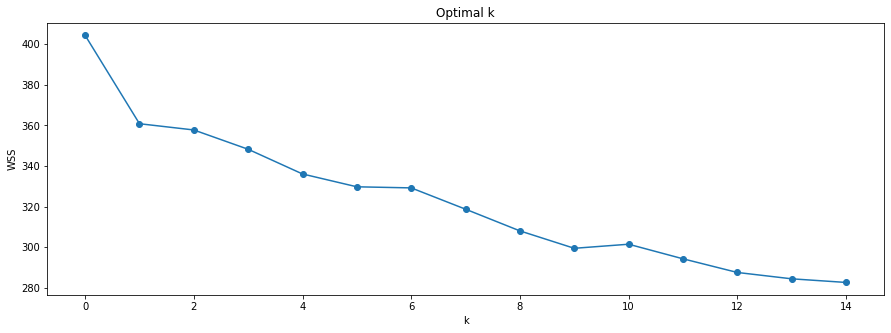

In [47]:
k_max = 15
xs = range(k_max)
wss = calculate_WSS(np.vstack(train_fake.vectors), k_max)
plt.figure(figsize=(15, 5))
plt.title("Optimal k")
plt.ylabel('WSS')
plt.xlabel('k')
plt.plot(xs, wss, 'o-');

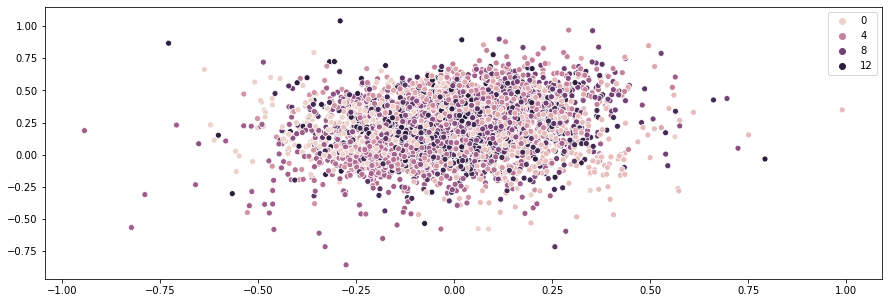

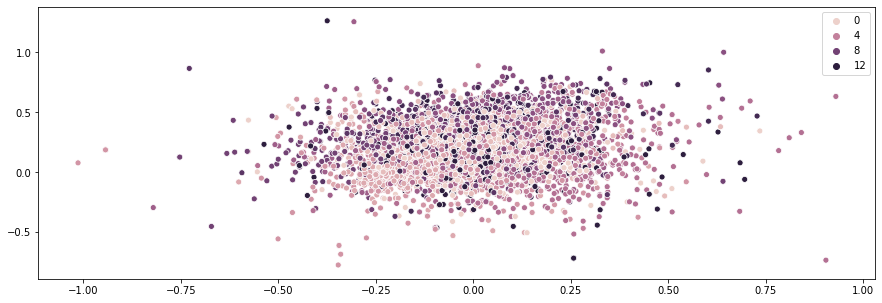

In [48]:
# wybieramy 12 klastrów
train_fake['class'] = plot_kmeans(np.vstack(train_fake.vectors) , n_clusters=12) 
test_fake['class'] = plot_kmeans(np.vstack(test_fake.vectors) , n_clusters=12) 

In [49]:
X['class']=train_fake['class']
X_test['class']=test_fake['class']

In [50]:
X.shape, X_test.shape

((4862, 784), (4863, 784))

In [52]:
y = get_y(train_fake)

Możemy sprawdzić najpierw na XGBClassifier - to był mój model bazowy

roc_auc: 0.6941596812012257 0.004750654116004268
AUC is: 0.6110122448979591


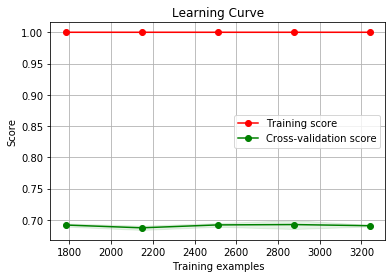

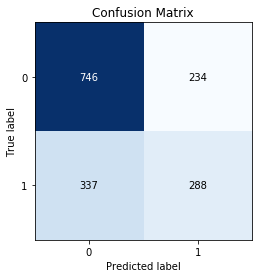

In [53]:
model = xgb.XGBClassifier(max_depth=7, n_estimators=50, random_state=0)
predict_and_plot(X, y, model)
plot_conf_matrix(X, y, model)

A teraz LSTM

In [54]:
X = X.to_numpy()
X = X.reshape(-1, 1, X.shape[1])
X.shape

(4862, 1, 784)

In [59]:
model = Sequential([
    LSTM(128, dropout=0.1, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),   
    LSTM(128, dropout=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    
])
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[AUC()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 128)            467456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 599,169
Trainable params: 599,169
Non-trainable params: 0
_________________________________________________________________


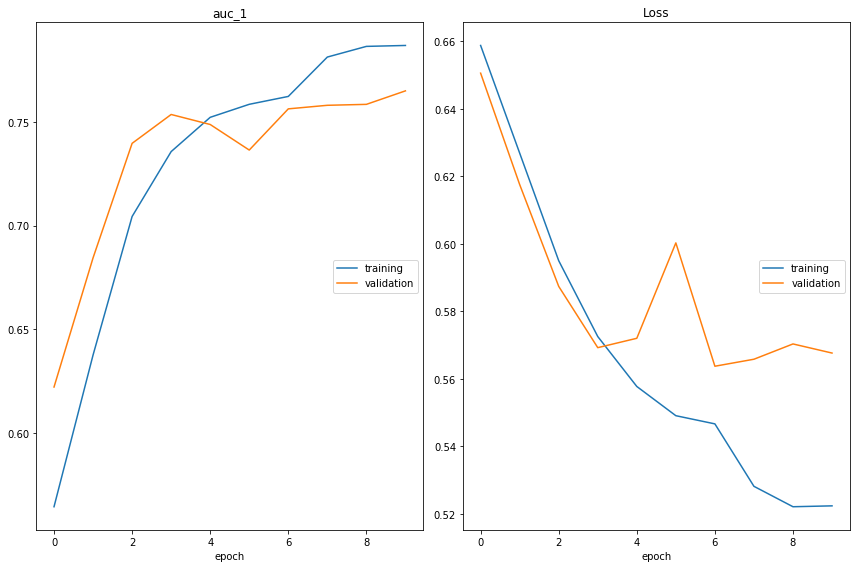

auc_1
	training         	 (min:    0.564, max:    0.787, cur:    0.787)
	validation       	 (min:    0.622, max:    0.765, cur:    0.765)
Loss
	training         	 (min:    0.522, max:    0.659, cur:    0.522)
	validation       	 (min:    0.564, max:    0.651, cur:    0.568)


In [60]:
model.fit(
        X, y, 
        epochs=10, batch_size=256,
        validation_split=0.2,
        callbacks=[PlotLossesKeras()],
        verbose=0)

In [ ]:
test_fake['is_fake'] = model.predict(X_test)
test_fake[ ['id', 'is_fake'] ].to_csv('{}.csv'.format('wynik'), index=False)